In [1]:
# Todo: sweet viz no final
# Testes estatísticos pra ver se as variáveis explicam o alvo e outros (teste de distribuição, normalidade)
# Criar pipeline pra essa ETL
# Separar ETAPAS de ETL, EDA e modelagem

# EDA (Exploratory Data Analysis)

## 1. Objetivo do notebook

Realizar análise exploratória dos dados respondendo as seguintes perguntas:

- Qual é o comportamento transacional do cliente (o que caracteriza as transações deste cliente)?

- Qual é o perfil das transações que retornaram chargeback?

Além disso, outras análises estatíticas de distribuições e relações

<u>Outputs</u>: Imagens em '../reports' e dataset de treino.

## 2. Carregamento das bibliotecas e dados

In [2]:
import pandas as pd
import sweetviz as sv
import numpy as np
from scipy import stats
from scipy.stats import shapiro, kstest

d:\Github Repos\missao-data-science-stoneco\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1 Utils

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_line_same_x(df, x, y_bar, y_line, fig_size=(12,6)):
    """
    Plota um gráfico de barras e um gráfico de linha no mesmo eixo x.

    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados.
    x (str): O nome da coluna que será usada no eixo x.
    y_bar (str): O nome da coluna que será usada para o gráfico de barras.
    y_line (str): O nome da coluna que será usada para o gráfico de linha.
    fig_size (tuple, opcional): O tamanho da figura (largura, altura). O padrão é (12, 6).

    Retorno:
    Visualizacao do plot + imagem salva na pasta reports
    """
    fig, ax1 = plt.subplots(figsize=fig_size)

    # Setting barplot
    ax1.bar(df[x], df[y_bar], color='darkgreen', alpha=0.6, label=y_bar)

    # Setting lineplot
    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y_line], color='lime', marker='o', label=y_line)

    # Setting labels and title
    ax1.set_xlabel(x)
    ax1.set_ylabel(y_bar, color='darkgreen')
    ax2.set_ylabel(y_line, color='lime')
    title = f'{y_bar} and {y_line} por {x}'
    plt.title(title)

    # Rotating x-ticks
    plt.xticks(rotation=180)

    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.savefig(f'../reports/{title.lower().replace(" ", "_")}.png', bbox_inches='tight')

    plt.show()


def boxplot_compare(df, x, y, fig_size=(12,6), binary_label=True):
    """
    Plota um boxplot para comparar distribuições entre duas variáveis.

    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados.
    x (str): O nome da coluna que será usada no eixo x.
    y (str): O nome da coluna que será usada no eixo y.
    fig_size (tuple, opcional): O tamanho da figura (largura, altura). O padrão é (12, 6).
    binary_label (bool, opcional): Se True, personaliza os rótulos do eixo x para 'Nao' e 'Sim'. O padrão é True.

    Retorno:
    Visualizacao do plot + imagem salva na pasta reports
    """
    plt.figure(figsize=fig_size)

    sns.boxplot(x=x, y=y, data=df, color='darkgreen')

    title = f'distribuicoes {y} por {x}'
    plt.title(title)

    plt.xlabel(x)
    plt.ylabel(y)

    # Customizing x-ticks
    if binary_label:
        plt.xticks([0, 1], ['Nao', 'Sim'])

    plt.savefig(f'../reports/{title.lower().replace(" ", "_")}.png', bbox_inches='tight')

def pivot_heatmap(pivot_df, x, y, fig_size=(12,6)): 
    """
    Plota um heatmap para uma tabela pivot.

    Parâmetros:
    pivot_df (DataFrame): O DataFrame contendo os dados pivotados com contagem de chargeback.
    x (str): O nome da coluna que será usada no eixo x.
    y (str): O nome da coluna que será usada no eixo y.
    fig_size (tuple, opcional): O tamanho da figura (largura, altura). O padrão é (12, 6).

    Retorno:
    Visualizacao do plot + imagem salva na pasta reports
    """
    plt.figure(figsize=fig_size)

    # Heatmap
    dark_green_palette = sns.dark_palette("green", reverse=True, as_cmap=True)
    sns.heatmap(pivot_df, cmap=dark_green_palette, annot=True, fmt='d')

    plt.xlabel(x)
    plt.ylabel(y)

    title = f'Chargebacks em {y} vs. {x}'
    plt.title(title)
    plt.savefig(f'../reports/{title.lower().replace(" ", "_")}.png', bbox_inches='tight')

    plt.show()

def simple_bar(df, x, y, fig_size=(12,6), binary_label=True):
    """
    Plota um gráfico de barras simples.

    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados.
    x (str): O nome da coluna que será usada no eixo x.
    y (str): O nome da coluna que será usada no eixo y.
    fig_size (tuple, opcional): O tamanho da figura (largura, altura). O padrão é (12, 6).
    binary_label (bool, opcional): Se True, personaliza os rótulos do eixo x para 'Nao' e 'Sim'. O padrão é True.

    Retorno:
    Visualizacao do plot + imagem salva na pasta reports
    """
    plt.figure(figsize=fig_size)

    df.plot(x=x, y=y, kind='bar', stacked=True, color='darkgreen', )

    # Adding labels and title
    plt.xlabel(x)
    plt.ylabel(y)
    title = f'{y} for {x}'
    plt.title(title)

    # Customizing the x-axis labels
    plt.xticks(rotation=0)
    if binary_label:
        plt.xticks([0, 1], ['Nao', 'Sim'])

    plt.legend(title={x})
    plt.savefig(f'../reports/{title.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

def pareto_freq_plot(df, target, fig_size=(12,6)):
    """
    Plota um gráfico de Pareto para frequência e porcentagem acumulada em casos de chargeback = 1

    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados de chargeback = 1 com colunas de frequencia e soma cumulativas.
    target (str): O nome da coluna alvo para o gráfico de Pareto.
    fig_size (tuple, opcional): O tamanho da figura (largura, altura). O padrão é (12, 6).

    Retorno:
    Visualizacao do plot + imagem salva na pasta reports
    """
    fig,ax1 = plt.subplots(figsize=fig_size)

    color1 = 'darkgreen'
    ax1.set_ylabel(f'Frequência (%) {target}',color = color1)
    ax1.bar(df[target], df['freq%'],color = color1,linewidth = 1,\
       hatch = '*')
    
    ax1.tick_params(axis = 'y',labelcolor = color1)

    color2 = 'lime'
    ax2 = ax1.twinx() # compartilhar o mesmo eixo x
    ax2.set_ylabel('% chargebacks',color = color2) 

    ax2.plot(df[target], df['cumulative_sum%'],color = color2,marker = 's',markersize = 8, linestyle = '-')

    ax2.tick_params(axis = 'y',labelcolor = color2)
    ax2.set_ylim([0,120])

    ax2.axhline(y=20, color='red', linestyle='--', linewidth=1)
    
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    title = f'Pareto {target} vs chargebacks'
    plt.title(title)
    plt.savefig(f'../reports/{title.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

### 2.2 Data

In [4]:
df = pd.read_csv('../data/processed/card_transactions_cbk_prepared.csv', dtype = {'flag_feriado': 'str',
                                                                                  'bandeira_cartao':'str',
                                                                                  'emissor_cartao': 'str'},
                                                                                  parse_dates=['Dia'])

In [5]:
df.dtypes

Dia                datetime64[ns]
Valor                     float64
Cartão                     object
CBK                         int64
periodo_do_dia             object
dia_da_semana              object
flag_feriado               object
bandeira_cartao            object
emissor_cartao             object
dtype: object

## 3. Análises graficas

### 3.1 Comportamento transacional do cliente/solicitante de chargeback

3.1.1 Por dia

In [6]:
daily_transactions = df.groupby('Dia').agg(
    total_transactions=('CBK', 'size'),
    total_chargebacks=('CBK', 'sum'),
    mean_transaction_value=('Valor', 'mean'),
    sum_transaction_value=('Valor', 'sum')
).reset_index()

daily_transactions['proportion_chargebacks'] = daily_transactions['total_chargebacks'] / daily_transactions['total_transactions']

daily_transactions.head(3)

,Dia,total_transactions,total_chargebacks,mean_transaction_value,sum_transaction_value,proportion_chargebacks
0,2015-05-01,170,14,139.591059,23730.48,0.082353
1,2015-05-02,106,12,164.679623,17456.04,0.113208
2,2015-05-03,127,1,135.538819,17213.43,0.007874


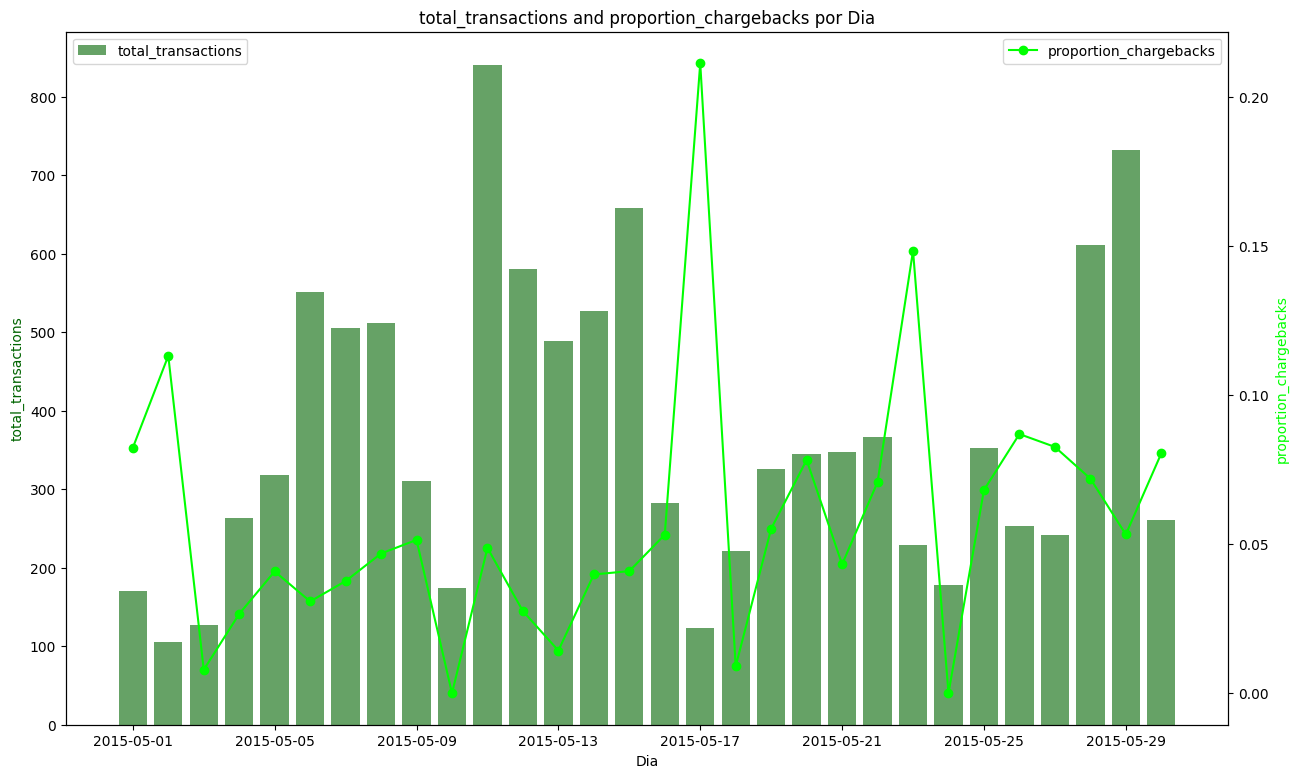

In [7]:
plot_bar_line_same_x(daily_transactions, x='Dia', y_bar='total_transactions', y_line='proportion_chargebacks', fig_size=(15,9))

Percebe-se que: nao necessariamente que o volume de chargebacks é proporcional ao volume de transacoes. Nao é possível concluir trends ou sazonalidade por nao ter mais dados de um mesmo período em anos diferentes ou diferentes temporadas no momento, mas seria um estudo a ser feito: 'é possivel concluir que ocorrem mais chargebacks no meio pro final do mës todos os meses?', otimizando a solucao para estes períodos

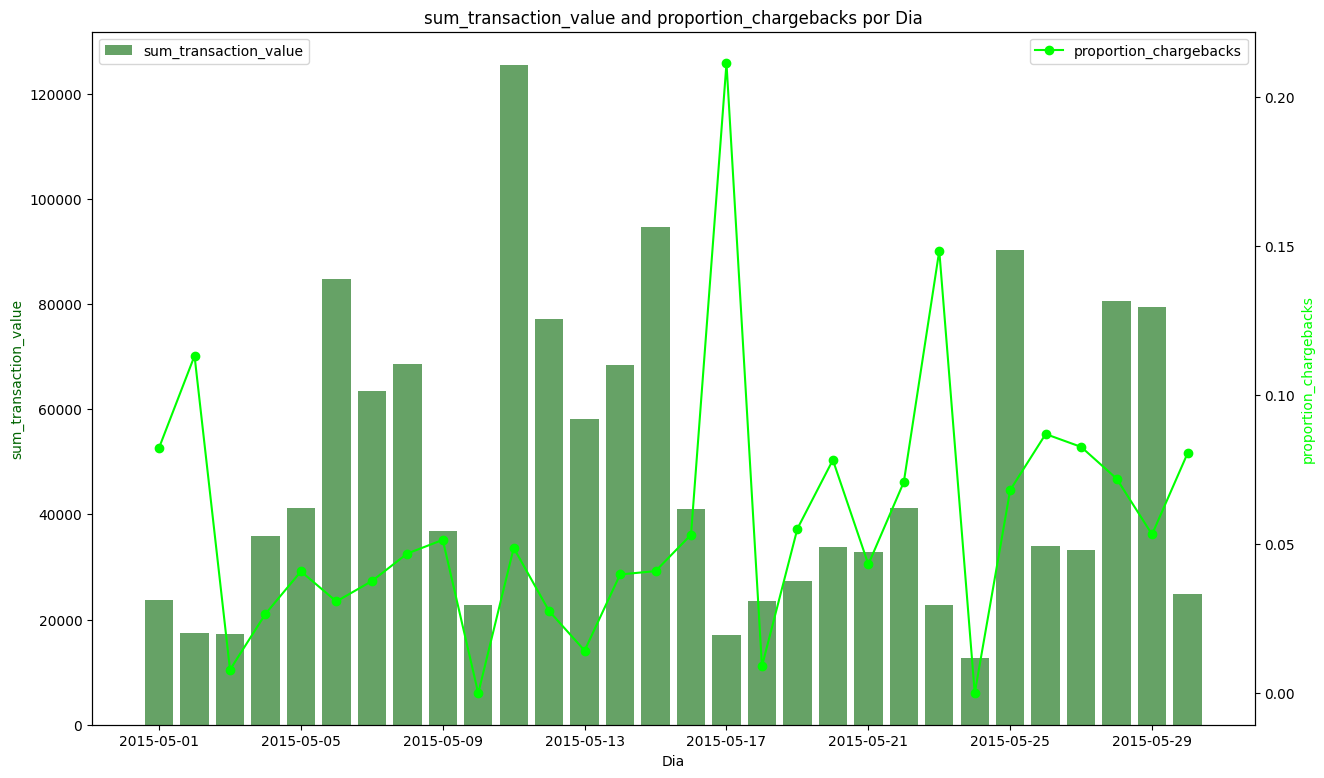

In [8]:
plot_bar_line_same_x(daily_transactions, x='Dia', y_bar='sum_transaction_value', y_line='proportion_chargebacks', fig_size=(15,9))

Em uma análise visual, a porcentagem de chargebacks no dia também nao parece ser correlato ao valor total de transacoes, podendo ver futuramente por ticket médio em uma analise mais profunda que capturasse outliers

3.1.2 Por valor

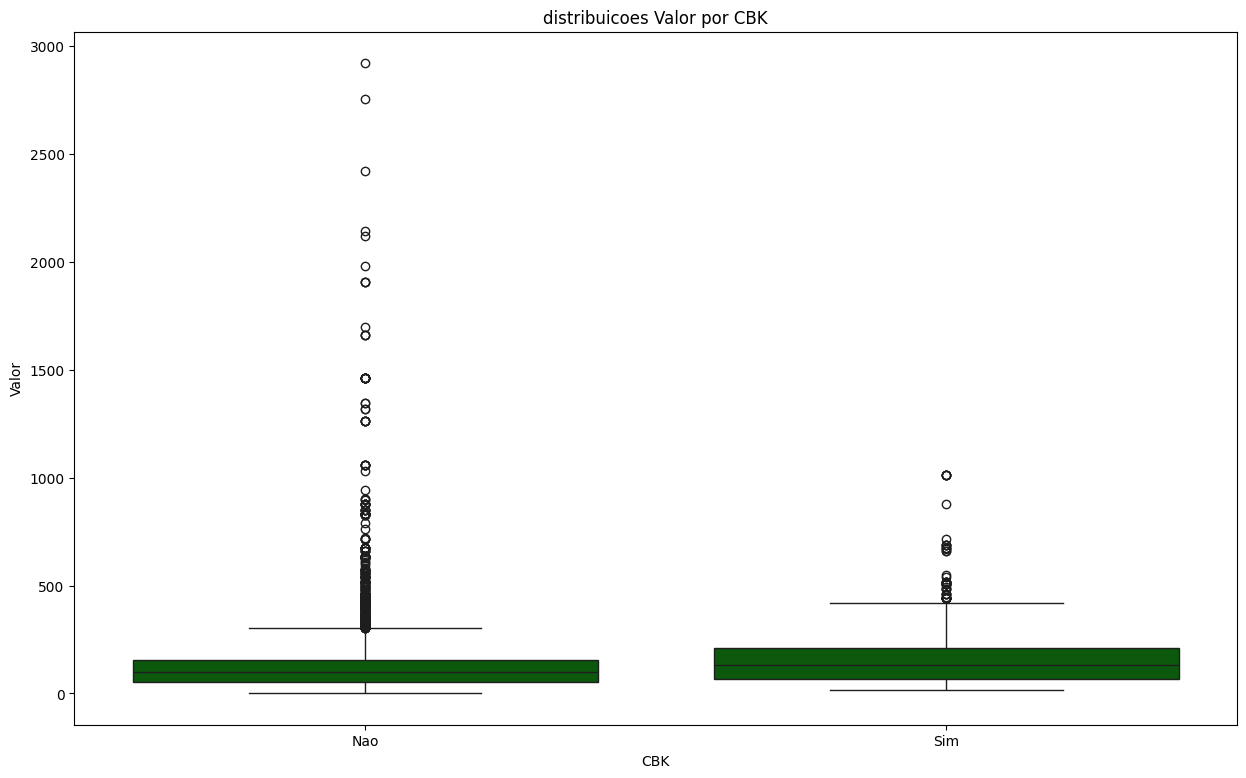

In [9]:
boxplot_compare(df, 'CBK', 'Valor', fig_size=(15,9))

Aparentemente o valor médio das transacoes neste período náo possui diferenca entre chargebacks e nao chargebacks, mas chargeback demonstrou ter valores mais baixos no geral e valores náo tao altos.

3.1.3 Por dia da semana e periodo do dia

In [10]:
tod_dow_pivot = df.pivot_table(index='periodo_do_dia', columns='dia_da_semana', aggfunc='size', fill_value=0)

period_order = ['dia', 'tarde', 'noite', 'madrugada']
days_order = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
tod_dow_pivot = tod_dow_pivot.reindex(index=period_order, columns=days_order)

tod_dow_pivot

dia_da_semana,Segunda-feira,Terça-feira,Quarta-feira,Quinta-feira,Sexta-feira,Sábado,Domingo
periodo_do_dia,,,,,,,
dia,267,292,322,401,398,169,67
tarde,694,580,570,704,1099,540,208
noite,699,550,656,799,822,378,310
madrugada,17,56,80,86,121,102,17


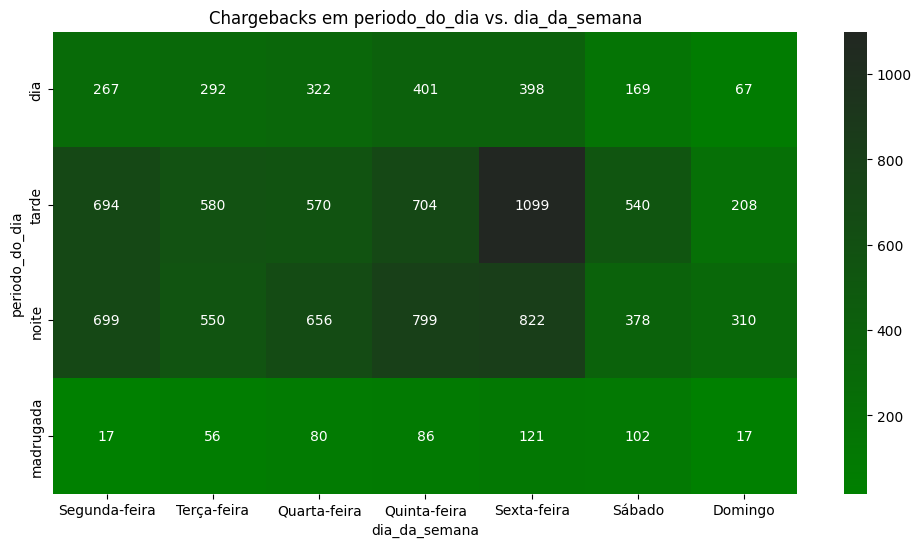

In [11]:
pivot_heatmap(tod_dow_pivot, x=tod_dow_pivot.columns.name, y=tod_dow_pivot.index.name, fig_size=(12,6))

3.1.4 Por feriado

<Figure size 1200x600 with 0 Axes>

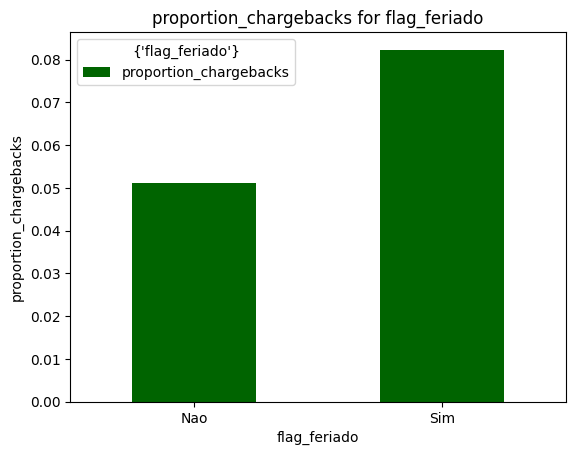

In [12]:
holiday_transactions = df.groupby('flag_feriado').agg(
    total_transactions=('CBK', 'size'),
    total_chargebacks=('CBK', 'sum'),
    mean_transaction_value=('Valor', 'mean'),
    sum_transaction_value=('Valor', 'sum')
).reset_index()

holiday_transactions['proportion_chargebacks'] = holiday_transactions['total_chargebacks'] / holiday_transactions['total_transactions']

simple_bar(holiday_transactions, 'flag_feriado', 'proportion_chargebacks', fig_size=(12,6))

3.1.5 Por bandeira do cartao

In [13]:
brand_transactions = df.groupby(['bandeira_cartao']).agg(
    total_transactions=('CBK', 'size'),
    total_chargebacks=('CBK', 'sum'),
    mean_transaction_value=('Valor', 'mean'),
    sum_transaction_value=('Valor', 'sum')
).reset_index()

brand_transactions['proportion_chargebacks'] = brand_transactions['total_chargebacks'] / brand_transactions['total_transactions']


In [14]:
brand_transactions.head(2)

,bandeira_cartao,total_transactions,total_chargebacks,mean_transaction_value,sum_transaction_value,proportion_chargebacks
0,4,5841,268,131.23347,766534.7,0.045883
1,5,5163,300,128.65491,664245.3,0.058106


<Figure size 1200x600 with 0 Axes>

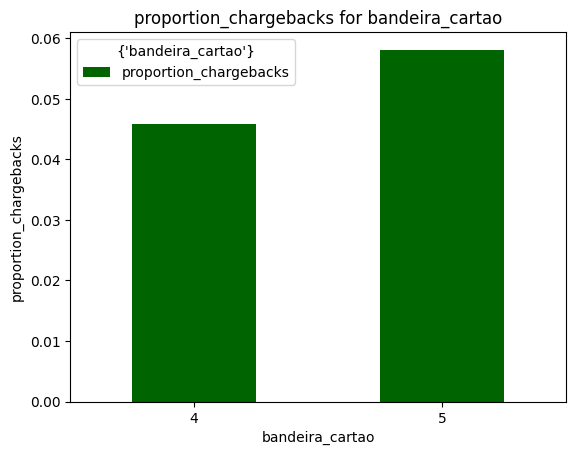

In [15]:
simple_bar(brand_transactions, 'bandeira_cartao', 'proportion_chargebacks', fig_size=(12,6), binary_label=False)

3.1.6 Por emissor de cartao: Pareto. 

Observacao dos principais emissores em casos de chargeback

In [16]:
cbk_transactions = df[df['CBK']==1].copy()

In [17]:
issuer_counts = cbk_transactions['emissor_cartao'].value_counts().to_frame('Count').rename_axis('emissor_cartao').reset_index()
issuer_counts.head(2)

,emissor_cartao,Count
0,98407,31
1,44828,24


In [18]:
issuer_counts['freq%'] = issuer_counts["Count"]/issuer_counts["Count"].sum() * 100
issuer_counts['cumulative_sum%'] = issuer_counts['freq%'].cumsum()/issuer_counts['freq%'].sum() * 100

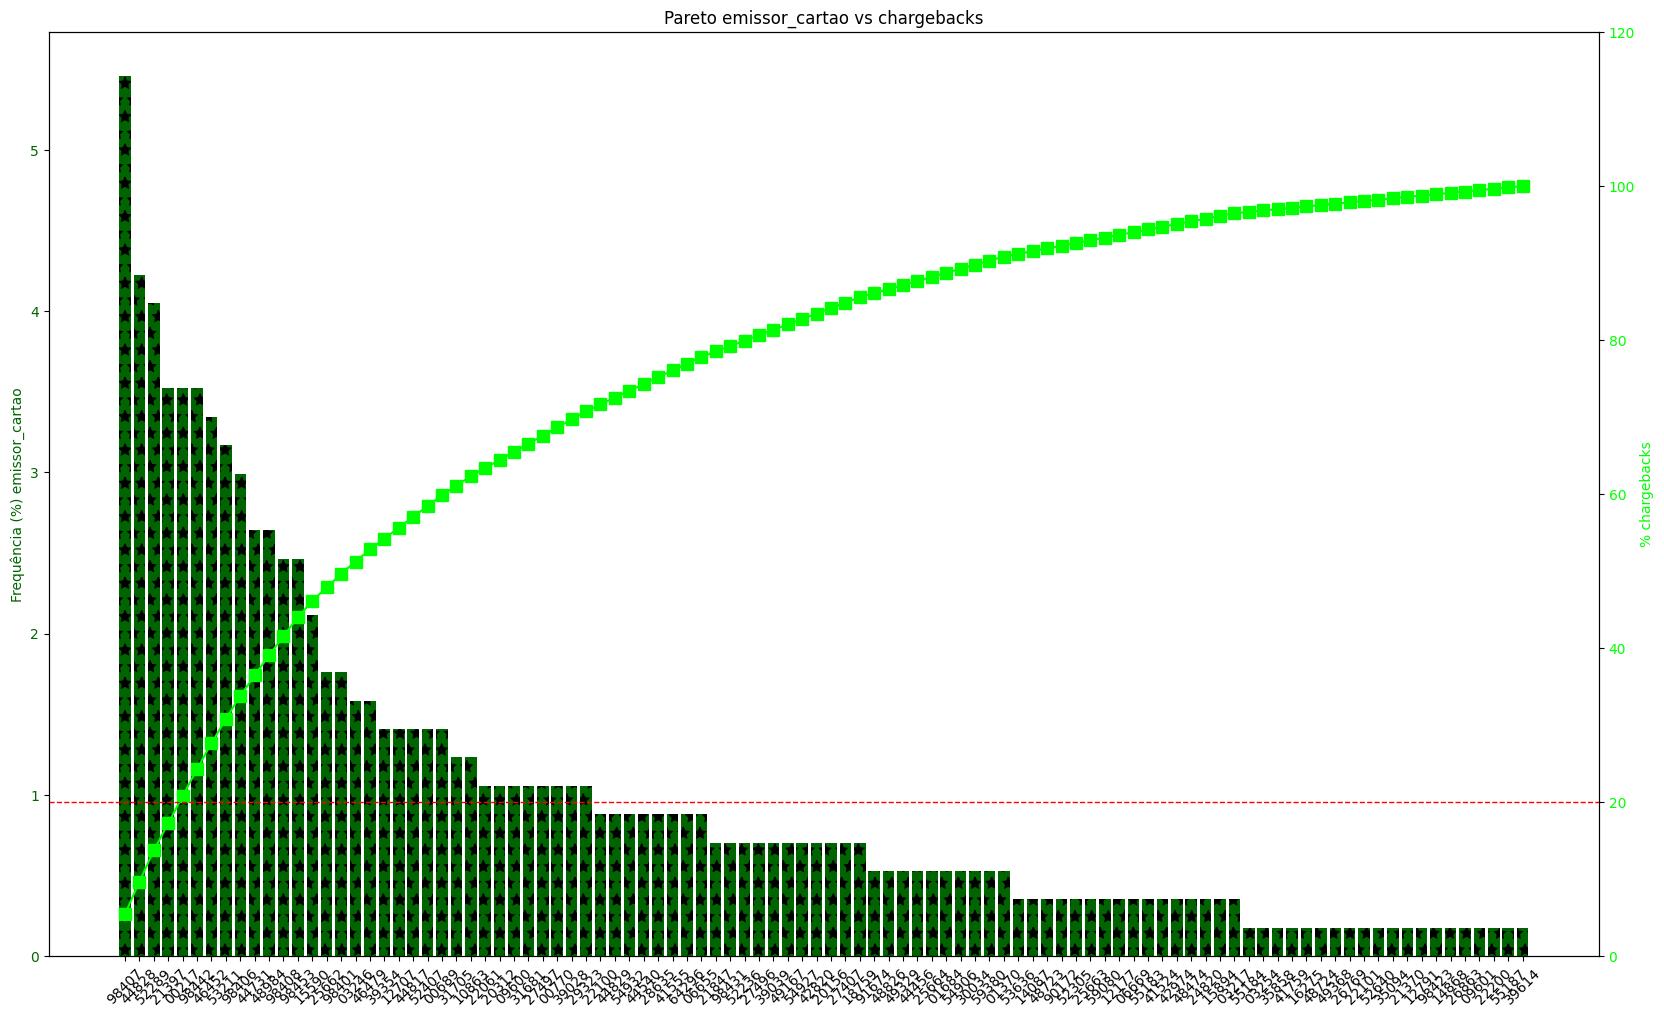

In [19]:
pareto_freq_plot(issuer_counts, target='emissor_cartao', fig_size=(20,12))

Concluindo que os emissores 98407, 44828, 52289, 21397 sao responsaveis por 20% dos chargebacks totais dentro do periodo estudado de maio

3.1.7 Mapa de correlacoes

## 4. Análises estatisticas

4.1 Teste de independência chi² e matriz de correlação com cramers v 

In [28]:
def cramers_v(x, y):
    """
    Calcula o coeficiente de associação Cramér's V entre duas variáveis categóricas.

    O coeficiente de associação de Cramér é uma medida de associação entre duas variáveis categóricas,
    que varia de 0 (sem associação) a 1 (associação completa). Ele é calculado a partir de uma tabela de contingência
    (também conhecida como matriz de confusão) entre as duas variáveis.

    Ele é especialmente útil para identificar relações entre variáveis em tabelas de contingência,
    onde cada célula da tabela representa a frequência de ocorrência conjunta de duas categorias.
    O coeficiente de Cramér's V fornece uma medida normalizada de associação que varia de 0 a 1,
    onde valores mais próximos de 1 indicam uma associação mais forte entre as variáveis.

    Parâmetros:
    x (array-like or pd.Series): A primeira variável categórica.
    y (array-like or pd.Series): A segunda variável categórica a ser comparada com a primeira

    Retorno:
    float: O coeficiente de associação Cramér's V entre as variáveis x e y.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(confusion_matrix)

    if 'CBK' in x.name:
        if p < 0.05:
            print(f"\nThere is a significant association between {x.name} and {y.name} occurrence.")
        else:
            print(f"\nThere is no significant association between {x.name} and {y.name} occurrence.")

    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


There is a significant association between CBK and Valor occurrence.

There is a significant association between CBK and periodo_do_dia occurrence.

There is a significant association between CBK and dia_da_semana occurrence.

There is no significant association between CBK and flag_feriado occurrence.

There is a significant association between CBK and bandeira_cartao occurrence.

There is a significant association between CBK and emissor_cartao occurrence.

There is a significant association between CBK and CBK occurrence.


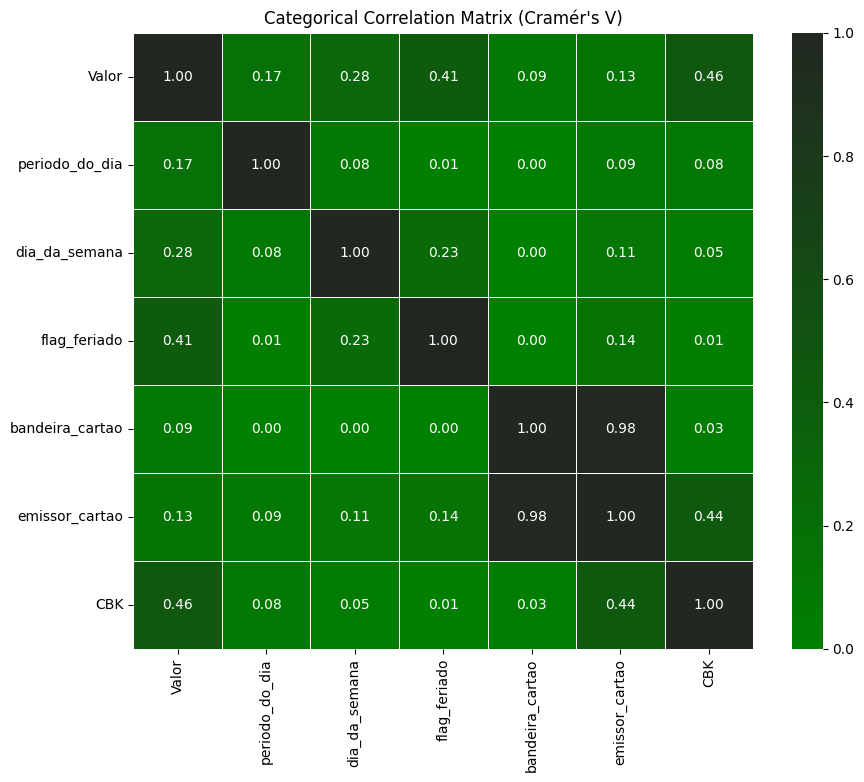

In [34]:
# Selecao das colunas relevantes para analise
categorical_columns = ['Valor', 'periodo_do_dia', 'dia_da_semana', 'flag_feriado', 'bandeira_cartao', 'emissor_cartao', 'CBK']

# Construcao da matrix de correlacao com os resultados de Cramér's V para cada par de variaveis da lista
categorical_correlation = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        categorical_correlation.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Plot
plt.figure(figsize=(10, 8))
dark_green_palette = sns.dark_palette("green", reverse=True, as_cmap=True)
sns.heatmap(categorical_correlation.astype(float), annot=True, cmap=dark_green_palette, fmt=".2f", linewidths=0.5)
plt.title("Categorical Correlation Matrix (Cramér's V)")
plt.show()

4.2 Estatísticas de distribuição

In [ ]:
stat, p = shapiro(df['Valor'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
     print('Probably Gaussian')
else:
     print('Probably not Gaussian')

stat=0.596, p=0.000
Probably not Gaussian


d:\Github Repos\missao-data-science-stoneco\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11004.
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
stat, p = kstest(df['Valor'], 'norm')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
     print("Fail to reject the null hypothesis: The sample is from a normal distribution.")  
else:
     print("Reject the null hypothesis: The sample is not from a normal distribution.")

stat=0.999, p=0.000
Reject the null hypothesis: The sample is not from a normal distribution.


4.3 Conclusão

Em poucas palavras, percebe-se que 
1. A variável flag feriado tem muito baixa correlação ou associação com a variável target, então deve ser removida do dataset para modelagem a fim de evitar ruídos. 
2. Bandeira do cartão é redundante à emissor do cartão. Como esta última tem maior relação com o alvo e não tão alta correlação a ponto de ser um overfit (intuitivamente), remove-se também esta primeira.

In [35]:
df_train = df.drop(columns=['Dia', 'Cartão', 'flag_feriado', 'bandeira_cartao'])
df_train.head()

,Valor,CBK,periodo_do_dia,dia_da_semana,emissor_cartao
0,36.54,0,madrugada,Sexta-feira,36518
1,36.54,0,madrugada,Sexta-feira,36518
2,69.00,0,madrugada,Sexta-feira,53211
3,193.43,0,madrugada,Sexta-feira,48827
4,132.00,0,madrugada,Sexta-feira,31681


#5. Sweetviz report

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



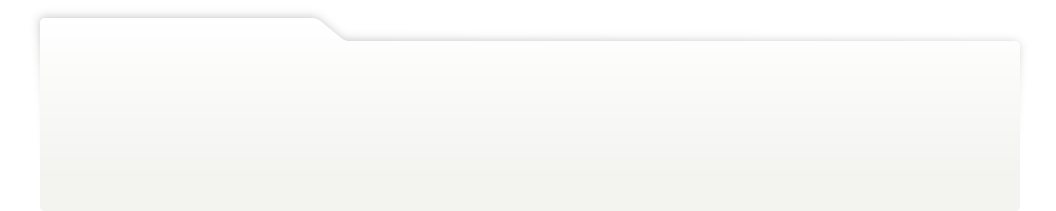
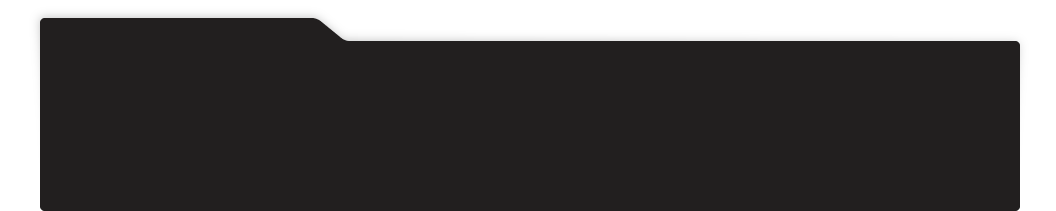
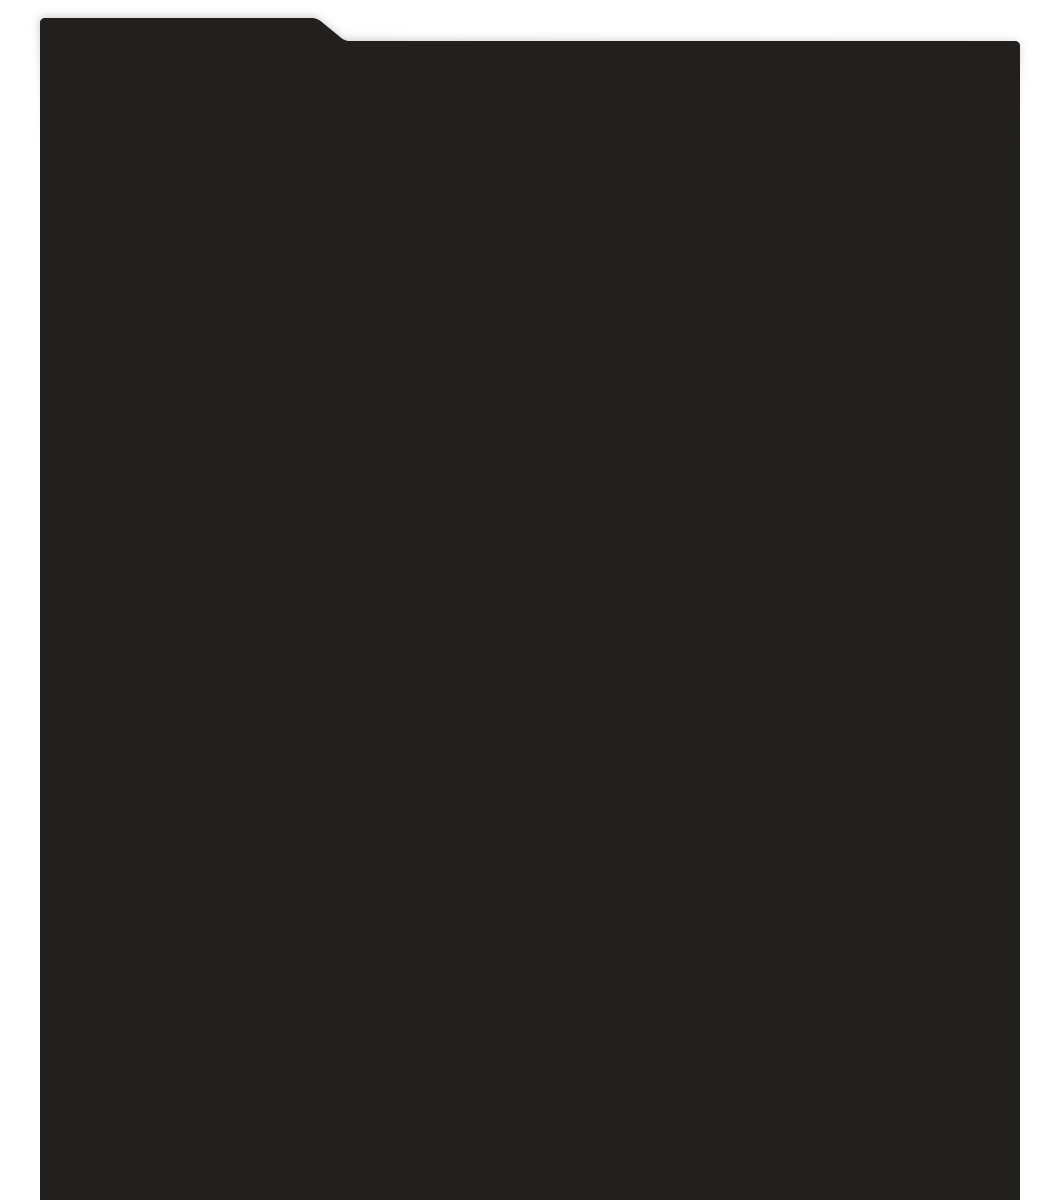
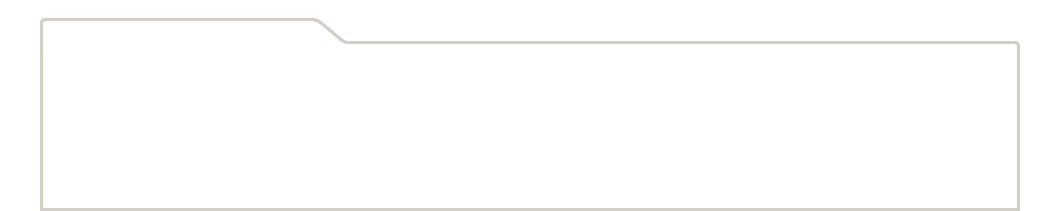
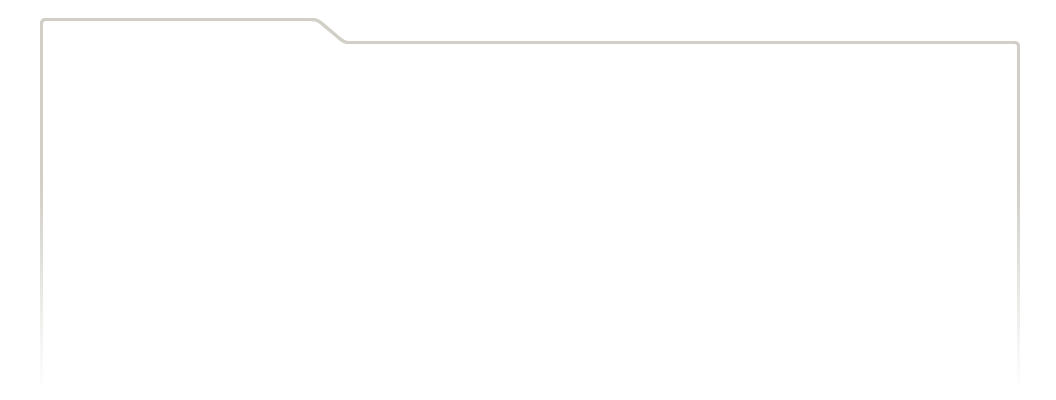
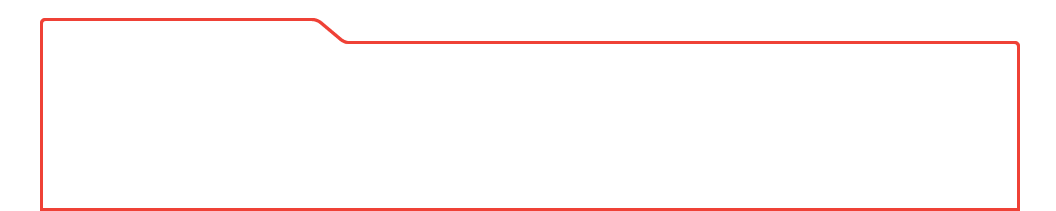
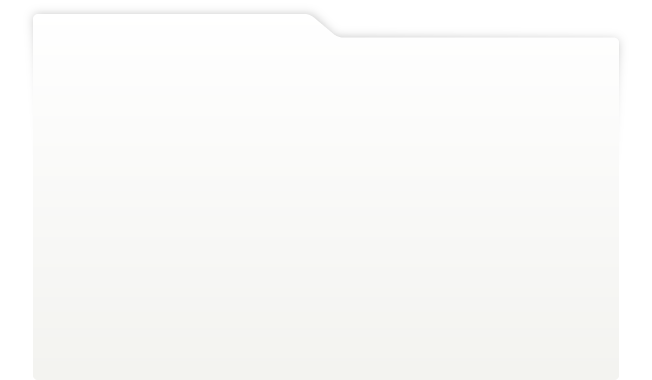
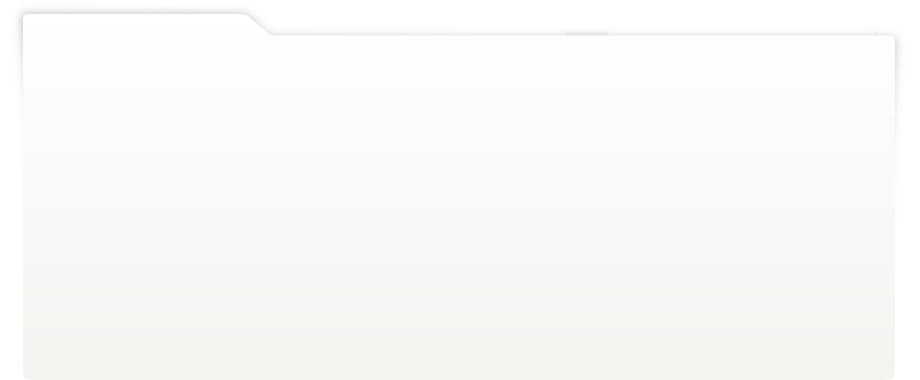
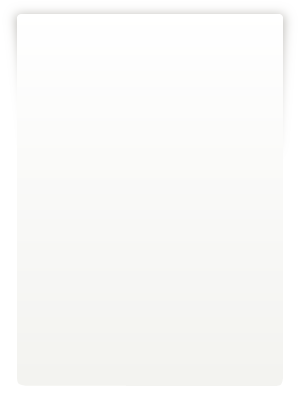
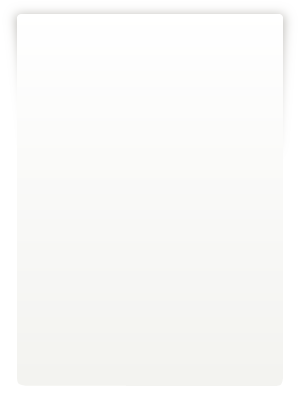
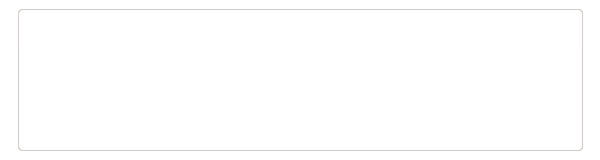
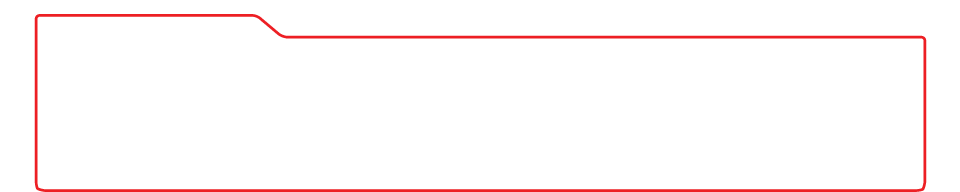
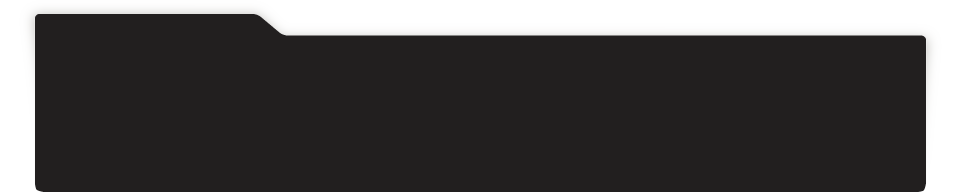
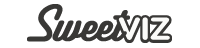
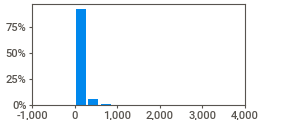
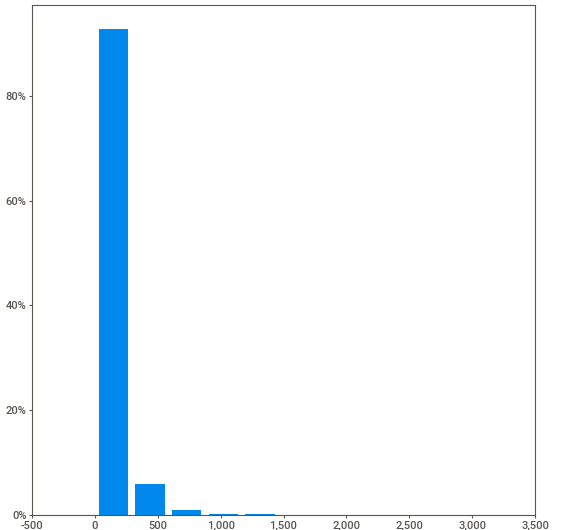
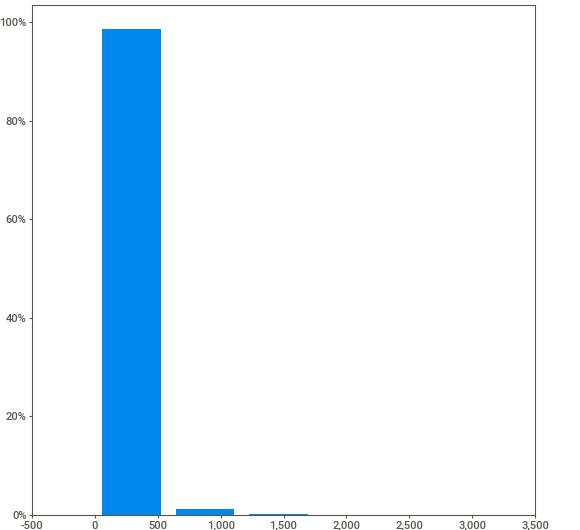
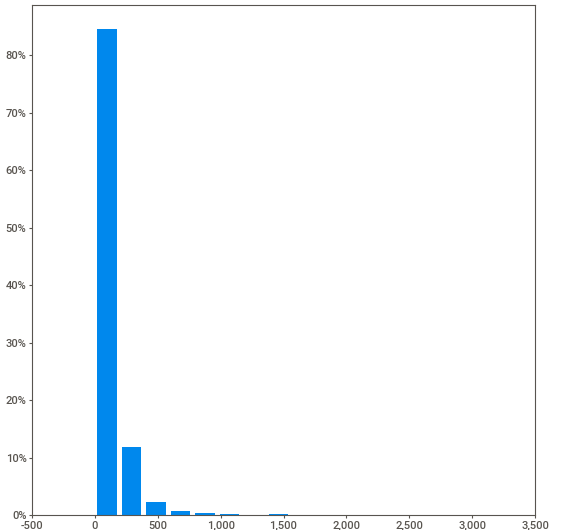
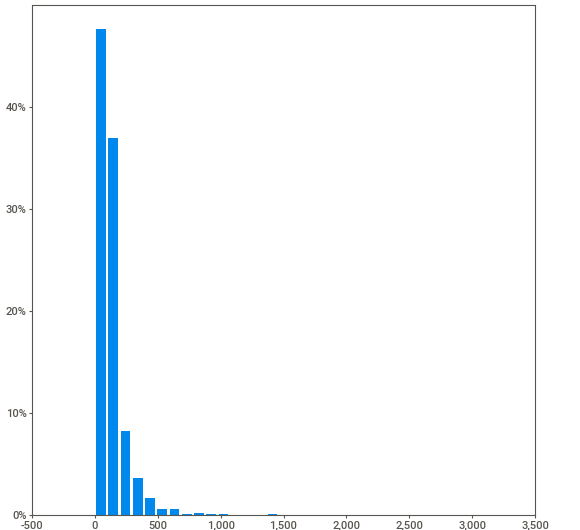
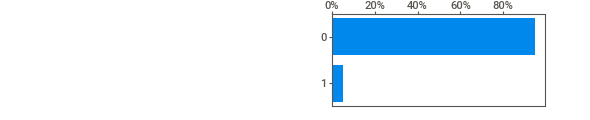
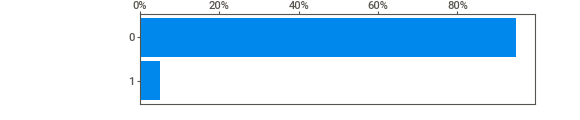
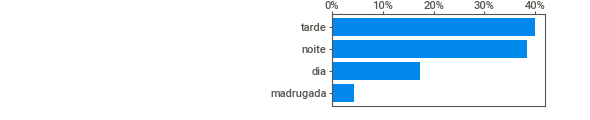
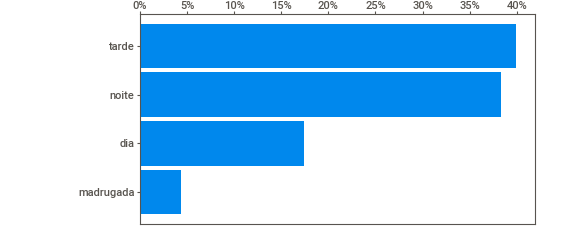
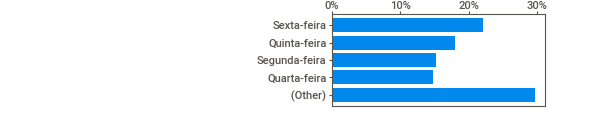
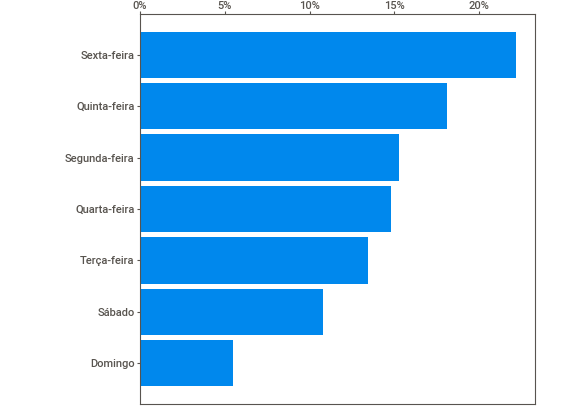
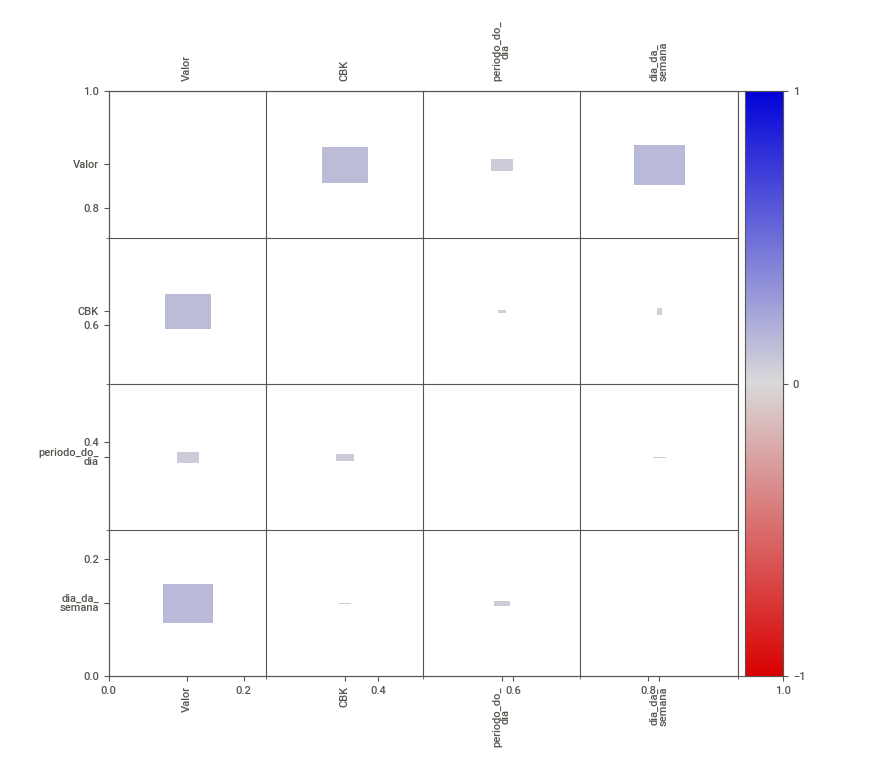
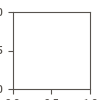

In [40]:
sv_report = sv.analyze(df_train)
sv_report.show_notebook()